# RM 294 - Optimization I
# FA Track Project 1: Linear Programming
# Dedicated / Cash Flow Matched Portfolio

#### Team Members:
- **Aritra Chowdhury _(ac79277)_**
- **Casey Copeland _(cmc6793)_**
- **Emilio Cabrera _(eac4622)_**
- **Rohitashwa Chakraborty _(rc47878)_**

### Part 1 - Dedicated Portfolio Build

#### Import required Libraries

In [33]:
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

#### Read Bonds and Liabilities CSV Files
We also print the number of years and bonds in the 2 respective files.

In [34]:
df_bonds = pd.read_csv("bonds.csv", index_col="Bond")
df_liabilities = pd.read_csv("liabilities.csv", index_col="Year")

nyears = df_liabilities.shape[0]
print("Number of years:", nyears)

nbonds = df_bonds.shape[0]
print("Number of bonds:", nbonds)

Number of years: 8
Number of bonds: 13


#### Create Objective and Constraint Matrices

**Objective Function**

The objective function is the initial investment in bonds in Year 0, which we try to minimize. Note that there is no cash outflow for forward bonds (bonds starting after Year 0). Therefore, for N bonds:

$$ minimize \sum \limits _{i=1} ^{N} (P_{i} * {x}_{i}) $$

where  
$i$ = $i$th bond  
$P_{i}$ = Price of the $i$th bond  
$x_{i}$ = Quantity of the $i$th bond (to be optimized)  

**Constraint Function**

Our constraint entails that the cash outflow should equal the cash inflow. The cash outflow is given by $L_{t}$ which is the liability at year $t$. The cash inflow is a combination of the coupon prices received from bonds, the maturity prices of bonds at the expiration date and the outflow from paying the forward prices for forward bonds. Therefore, the constraint becomes:

$$ L_{t} = \sum \limits _{i=1} ^{N} (C_{i} * x_{i}) \mid (M_{i} > t-1, S_{i} > t-1) - \sum \limits _{i=1} ^{N} (P_{i} - {x}_{i}) \mid (S_{i} = t) + \sum \limits _{i=1} ^{N} (100 * x_{i}) \mid (M_{i} = t) $$

where  
$t$ = $t$th year  
$C_{i}$ = Coupon price of the $i$th bond  
$M_{i}$ = Maturity price of the $i$th bond

In [35]:
A = np.zeros((nyears+1, nbonds)) # nyears +1 because year = 0 is the investment.....to be minimised

for index, row in df_bonds.iterrows():
    price, coupon, start, maturity = row[["Price", "Coupon", "StartTime", "Maturity"]].apply(float)
    start = int(start)
    maturity = int(maturity)
    
    A[start, index-1] = -1*price                 # Outflow: buying a bond
    A[(start+1) : (maturity), index-1] = coupon  # Inflow : Coupon Payment
    A[maturity, index-1] = coupon + 100          # Inflow : Maturity = Coupon + FV ($100)

objective = -1*A[0]
A_bonds = A[1:]
print("Objective Function (to be minimized):\n", objective)
print("\nDimensions of Matrix (A):", A_bonds.shape)

Objective Function (to be minimized):
 [102.  -0.  99. 101.  98.  98.  -0. 104. 100. 101. 102.  94.  -0.]

Dimensions of Matrix (A): (8, 13)


In [36]:
sense = np.array((['=']*nyears))
b_liabilities = np.array(df_liabilities)

### Part 2 - Dedicated Portfolio Solution using Gurobi

In [37]:
model = gp.Model() # initialize an empty model

modX = model.addMVar(nbonds)

modCon = model.addMConstrs(A_bonds, modX, sense, b_liabilities) # add model constraints

model.setMObjective(None,objective,0,sense=gp.GRB.MINIMIZE)

model.Params.OutputFlag = 0

model.optimize() # solve the LP

After solving the problem using Gurobi, we get the following results.

In [38]:
print("Cost of portfolio: $",round(model.objVal,2),"\n")

print("We buy the following bond quantities at Year 0:\n")
for i in range(len(modX.x)):
    if (modX.x[i] > 0.0):
        print("Bond {index} (@ ${price}): ".format(index = df_bonds.index[i], price = df_bonds["Price"].iloc[i]), round(modX.x[i],2))

Cost of portfolio: $ 9447500.76 

We buy the following bond quantities at Year 0:

Bond 1 (@ $102):  6522.49
Bond 3 (@ $99):  12848.62
Bond 5 (@ $98):  15298.32
Bond 6 (@ $98):  15680.78
Bond 8 (@ $104):  12308.01
Bond 10 (@ $101):  12415.73
Bond 11 (@ $102):  10408.99
Bond 12 (@ $94):  9345.79


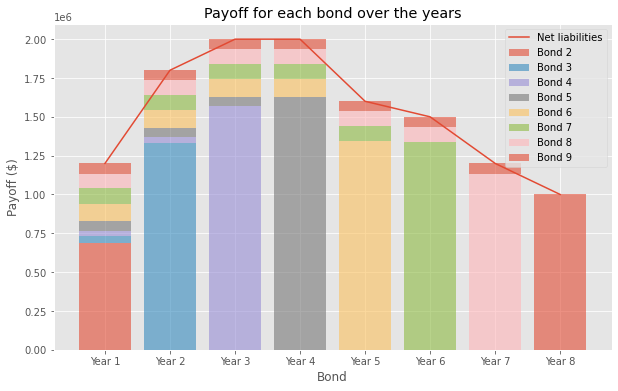

In [39]:
mask = modX.x > 0

used_A = A_bonds[:,mask]
used_b = modX.x[mask]

year_lst = ["Year "+str(i) for i in range(1,df_bonds["Maturity"].max()+1)]

plt.figure().set_size_inches(10, 6,  forward=True)

weight_prev = np.array([0]*used_A.shape[1])
for i in range(used_A.shape[1]):
    weight = used_A[:,i]*used_b[i]
    # plot bars in stack manner
    plt.bar(year_lst,weight, bottom=weight_prev, alpha = 0.6)
    weight_prev = np.add(weight_prev , weight)

plt.plot(year_lst, b_liabilities)
plt.xlabel("Bond")
plt.ylabel("Payoff ($)")
plt.title("Payoff for each bond over the years")
plt.legend(["Net liabilities"]+["Bond "+str(i+1) for i in range(1,df_bonds["Maturity"].max()+1)], loc = "best")
plt.show()

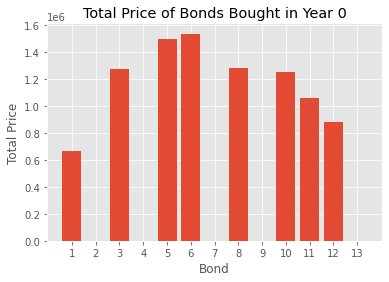

In [40]:
plt.bar(df_bonds.index, df_bonds["Price"]*modX.x)
plt.title("Total Price of Bonds Bought in Year 0")
plt.xlabel("Bond")
plt.ylabel("Total Price")
plt.xticks(np.arange(1, nbonds+1, 1.0))
plt.show();

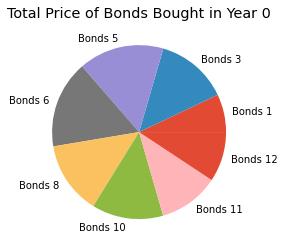

In [41]:
plt.pie((df_bonds["Price"]*modX.x)[modX.x > 0], labels=["Bonds "+str(i+1) for i in range(len(modX.x)) if modX.x[i] > 0])
plt.title("Total Price of Bonds Bought in Year 0")
plt.show();

Note that Bonds 2, 7 and 13 are forward contracts so we buy them and pay later. 

The portfolio generates exactly equal cash flows to the liabilities, which we confirm below. 

In [16]:
print("All Cash Flows matched?:", all(list(map(int, A_bonds@(modX.x.T))) == b_liabilities.T[0]))

All Cash Flows matched?: True


### Part 5 - Flexibility of Portfolio in case of Changes in Liability

To understand the flexibility of the Portfolio in case of changes in liability, we first look at the following outcomes.

**Outcome 1**

If some of our employees were to quit without notice and don’t need a replacement, this will reduce the liabilities. In the case of our annual liabilities decreasing, the current portfolio would have a surplus and our liabilities set at time zero could still be met.

**Outcome 2**

If some employees were to quit without notice and the new replacement requests a higher salary than the previous employee, then our annual liabilities will increase. In the case of annual liabilities increasing, our portfolio would have a deficit and we would need to adjust the portfolio at that year in order to meet future liability payments.

The magnitude at which the Portfolio cost will change according to a change in Liability depends on the year and can be understood from the Shadow Prices of the respective year. The Shadow Prices are calculated below.

In [42]:
df_portfolio_flexibility = pd.DataFrame()

df_portfolio_flexibility['Year'] = np.array(range(1, nyears+1))
df_portfolio_flexibility['Shadow Price'] = np.array([con.Pi for con in modCon]) 
df_portfolio_flexibility['Lower Bound'] = np.array([con.SARHSLow for con in modCon])
df_portfolio_flexibility['Upper Bound'] = np.array([con.SARHSUp for con in modCon])

df_portfolio_flexibility

,Year,Shadow Price,Lower Bound,Upper Bound
0,1,0.971429,5.151384e+05,inf
1,2,0.923671,4.701682e+05,2.205234e+07
2,3,0.909876,4.319224e+05,3.106210e+07
3,4,0.834424,3.691993e+05,2.089037e+07
4,5,0.653628,2.584273e+05,1.075133e+07
5,6,0.617183,1.591014e+05,1.261887e+07
6,7,0.530350,6.542056e+04,1.197295e+07
7,8,0.522580,-1.164153e-10,1.582050e+07


### Part 6 - Dedicated Portfolio using Real Bond Data from WSJ

Th Treasury Bond data from WSJ is current as of **6th October 2021**. We extract the data here using a CSV file.

In [43]:
scraped_bonds = pd.read_csv("wsj_bondsdata.csv")

In [44]:
scraped_bonds["MATURITY"] = pd.to_datetime(scraped_bonds["MATURITY"])

df_bonds_real = scraped_bonds[(scraped_bonds["MATURITY"].apply(lambda x: x.month) == pd.to_datetime("8/15/2021").month)&
                (scraped_bonds["MATURITY"].apply(lambda x: x.day) == pd.to_datetime("8/15/2021").day)][["MATURITY","COUPON","ASKED"]].copy()


df_bonds_real.insert(0, "StartTime", [0]*len(df_bonds_real))
df_bonds_real.insert(0, "Maturity", df_bonds_real.MATURITY.apply(lambda x: x.year - 2021))
df_bonds_real.rename_axis("Bonds", inplace=True)
df_bonds_real.rename(columns = {"COUPON":"Coupon", "ASKED":"Price", "MATURITY":"Expiration"}, inplace=True)
df_bonds_real.reset_index(drop = True, inplace = True)
df_bonds_real = df_bonds_real[df_bonds_real["Maturity"] <= 8]

nbonds = df_bonds_real.shape[0]
print("Number of bonds:", nbonds)
print("\nThe extracted bonds from WSJ are as shown below.")
df_bonds_real

Number of bonds: 18

The extracted bonds from WSJ are as shown below.


,Maturity,StartTime,Expiration,Coupon,Price
0,1,0,2022-08-15,1.500,101.066
1,1,0,2022-08-15,1.625,101.104
2,1,0,2022-08-15,7.250,106.032
3,2,0,2023-08-15,0.125,99.242
4,2,0,2023-08-15,2.500,104.050
5,2,0,2023-08-15,6.250,111.036
6,3,0,2024-08-15,0.375,99.204
7,3,0,2024-08-15,2.375,105.106
8,4,0,2025-08-15,2.000,104.240
9,4,0,2025-08-15,6.875,123.110


In [45]:
A = np.zeros((nyears+1, nbonds)) # nyears +1 because year = 0 is the investment.....to be minimised

for index, row in df_bonds_real.iterrows():
    price, coupon, start, maturity = row[["Price", "Coupon", "StartTime", "Maturity"]].apply(float)
    start = int(start)
    maturity = int(maturity)
    
    A[start, index] = -1*price                 # Outflow: buying a bond
    A[(start+1) : (maturity), index] = coupon  # Inflow : Coupon Payment
    A[maturity, index] = coupon + 100          # Inflow : Maturity = Coupon + FV ($100)

objective = -1*A[0]
A_bonds = A[1:]
print("Objective Function (to be minimized):\n", objective)
print("\nDimensions of Matrix (A):", A_bonds.shape)

Objective Function (to be minimized):
 [101.066 101.104 106.032  99.242 104.05  111.036  99.204 105.106 104.24
 123.11  102.176 127.162 106.11  129.284 110.164 127.262 101.28  135.262]

Dimensions of Matrix (A): (8, 18)


In [46]:
sense = np.array((['='] * nyears))
b_liabilities = np.array(df_liabilities)

### Solving the Model using Gurobi

In [47]:
model = gp.Model() # initialize an empty model

modX = model.addMVar(nbonds) # nbonds updated to 18

model.addMConstrs(A_bonds, modX, sense, b_liabilities) # add constraints to model

model.setMObjective(None, objective, 0, sense = gp.GRB.MINIMIZE)

model.Params.OutputFlag = 0

model.optimize() # solve the LP

After solving the problem using Gurobi, we get the following results.

In [48]:
print("Cost of portfolio: $",round(model.objVal,2),"\n")

print("We buy the following bond quantities at Year 0:\n")

for i in range(len(modX.x)):
    if modX.x[i] > 0.0:
        print("Bond {index} (Year {year}) (@ ${price}):".format(index = df_bonds_real.index[i] + 1, year = df_bonds_real["Expiration"][i].year, price = df_bonds_real["Price"].iloc[i]), round(modX.x[i],2))

Cost of portfolio: $ 11717495.64 

We buy the following bond quantities at Year 0:

Bond 3 (Year 2022) (@ $106.032): 6376.46
Bond 6 (Year 2023) (@ $111.036): 12838.75
Bond 8 (Year 2024) (@ $105.106): 15641.17
Bond 10 (Year 2025) (@ $123.11): 16012.65
Bond 12 (Year 2026) (@ $127.162): 13113.52
Bond 14 (Year 2027) (@ $129.284): 12998.68
Bond 16 (Year 2028) (@ $127.262): 10827.35
Bond 18 (Year 2029) (@ $135.262): 9422.85


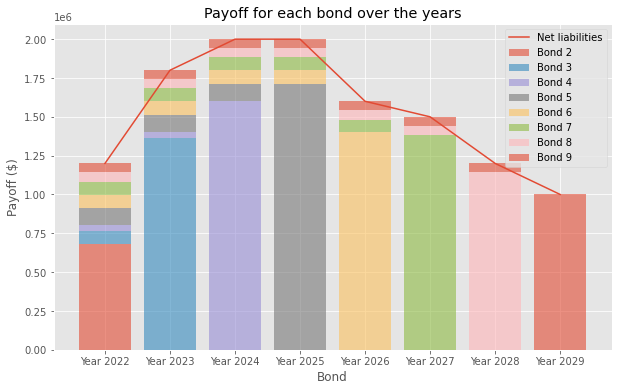

In [49]:
mask = modX.x > 0

used_A = A_bonds[:,mask]
used_b = modX.x[mask]

year_lst = ["Year "+str(i) for i in range(df_bonds_real["Expiration"].min().year,df_bonds_real["Expiration"].max().year+1)]

plt.figure().set_size_inches(10, 6,  forward=True)
weight_prev = np.array([0]*used_A.shape[1])
for i in range(used_A.shape[1]):
    weight = used_A[:,i]*used_b[i]
    # plot bars in stack manner
    plt.bar(year_lst,weight, bottom=weight_prev, alpha = 0.6)
    weight_prev = np.add(weight_prev , weight)

plt.plot(year_lst, b_liabilities)
plt.xlabel("Bond")
plt.ylabel("Payoff ($)")
plt.title("Payoff for each bond over the years")
plt.legend(["Net liabilities"]+["Bond "+str(i+1) for i in range(1,df_bonds["Maturity"].max()+1)], loc = "best")
plt.show()


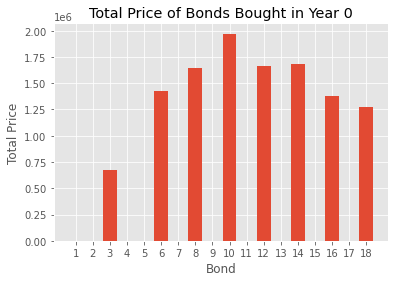

In [50]:
plt.bar(df_bonds_real.index + 1, df_bonds_real["Price"]*modX.x)
plt.title("Total Price of Bonds Bought in Year 0")
plt.xlabel("Bond")
plt.ylabel("Total Price")
plt.xticks(np.arange(1, nbonds+1, 1.0))
plt.show();

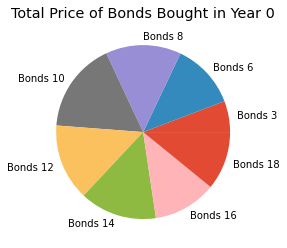

In [51]:
plt.pie((df_bonds_real["Price"]*modX.x)[modX.x > 0],
         labels=["Bonds "+str(i+1) for i in range(len(modX.x)) if modX.x[i] > 0])
plt.title("Total Price of Bonds Bought in Year 0")
plt.show();

The portfolio generates exactly equal cash flows to the liabilities

In [52]:
print("All Cash Flows matched?:", all(list(map(int, A_bonds@(modX.x.T))) == b_liabilities.T[0]))

All Cash Flows matched?: True


***
***